# 2019/W51: NBA Defensive Ratings

Data from [here](https://data.world/makeovermonday/2019w51)

# Load packages and import data

In [2]:
import pandas as pd
import altair as alt

In [3]:
df = pd.read_csv('https://query.data.world/s/fca6mx4ahx5hkutczjghdpnze7uwa7')
#df = pd.read_csv('https://query.data.world/s/n3pj6omagl3flwxbzs6mblkjroi45y', sep='\t', 
#                 thousands=',', encoding='utf_16_le')
df.head()

,SEASON,RANK,TEAM,G,W,L,DEF RTG,RTG vs. LEAGUE AVG
0,1996-97,1.0,Miami Heat,82.0,61.0,21.0,99.2,0.944948
1,1996-97,2.0,New York Knicks,82.0,57.0,25.0,99.5,0.947806
2,1996-97,3.0,Atlanta Hawks,82.0,56.0,26.0,100.3,0.955426
3,1996-97,4.0,Chicago Bulls,82.0,69.0,13.0,100.7,0.959237
4,1996-97,5.0,Cleveland Cavaliers,82.0,42.0,40.0,100.8,0.960189


Yesinfer_objectsept for the current one, 2019. 

And a quick `describe`.

In [21]:
df.dtypes

SEASON                 object
RANK                  float64
TEAM                   object
G                     float64
W                     float64
L                     float64
DEF RTG               float64
RTG vs. LEAGUE AVG    float64
dtype: object

Some numeric values are not in the right type. So I'll take a look and transform them.

One value has a `$` that is impeding the transformation to numeric. I'll fix this and alo some other changes to make the data looks better in the plot and creating a new column to see proportion as 

In [6]:
df_clean = df.copy()
df_clean['Clark County Gaming Revenue'] = pd.to_numeric(df_clean['Clark County Gaming Revenue'].str.replace('[,$]',''),
                                                       downcast='integer')
df_clean['Midweek Occupancy Percentage'] = pd.to_numeric(df_clean['Midweek Occupancy Percentage'].str.replace('%',''))
df_clean['Weekend Occupancy Percentage'] = pd.to_numeric(df_clean['Weekend Occupancy Percentage'].str.replace('%',''))
df_clean['Overall Occupancy Percentage'] = pd.to_numeric(df_clean['Overall Occupancy Percentage'].str.replace('%',''))

#Create new column
df_clean['Proportion'] = df_clean['Convention Attendance']/df_clean['Visitor Volume']
df_clean['Year'] = pd.to_datetime(df_clean['Year'], format='%Y')

df_clean.dtypes

Year                            datetime64[ns]
Months                                   int64
Visitor Volume                           int64
Convention Attendance                    int64
Room Inventory                           int64
Midweek Occupancy Percentage           float64
Weekend Occupancy Percentage           float64
Overall Occupancy Percentage           float64
LVCVA Room Tax Collections             float64
En/Deplaned Air Passenger                int64
Clark County Gaming Revenue              int64
Proportion                             float64
dtype: object

So the values are now in the correct format. Let's see if there are `NAs` and make the visualization.

In [7]:
df_clean.isnull().sum()

Year                             0
Months                           0
Visitor Volume                   0
Convention Attendance            0
Room Inventory                   0
Midweek Occupancy Percentage    13
Weekend Occupancy Percentage    13
Overall Occupancy Percentage     0
LVCVA Room Tax Collections       1
En/Deplaned Air Passenger        0
Clark County Gaming Revenue      0
Proportion                       0
dtype: int64

Three variables have NA values but I'll redo the original plot with two plots.

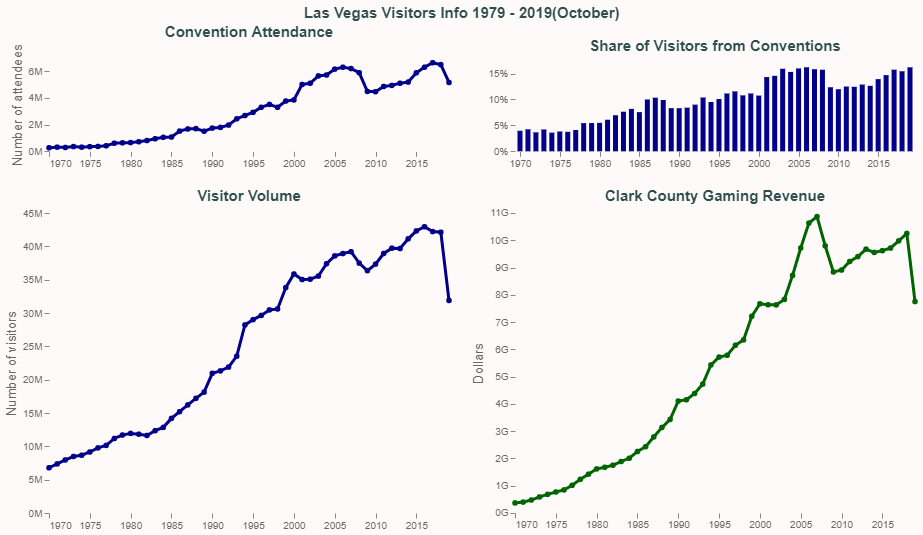

In [18]:
brush = alt.selection_interval(encodings=['x'],empty='all')

base_line_bar = alt.Chart(df_clean).encode(
    x=alt.X('Year', title=None),
    color=alt.condition(brush, alt.ColorValue('darkblue'), alt.ColorValue('gray')),
    tooltip=alt.Tooltip('year(Year):N')
).add_selection(
    brush
)

#Convention line/scatter
chart_convention = base_line_bar.mark_line(point=True, size=3).encode( 
    y=alt.Y('Convention Attendance', title='Number of attendees',
           axis=alt.Axis(format='~s'))
).properties(
    title='Convention Attendance',
    width=400,
    height=300*14/45
) 

#Visitor line/scatter
chart_visitors = base_line_bar.mark_line(point=True, size=3).encode( 
    y=alt.Y('Visitor Volume', title='Number of visitors',
           axis=alt.Axis(format='~s'))
).properties(
    title='Visitor Volume',
    width=400,
    height=300
)

#Conventionas proportion of total visitors
chart_proportion = base_line_bar.mark_bar().encode(
    y=alt.Y('Proportion', title=None,
           axis=alt.Axis(format='%'))
).properties(
    title='Share of Visitors from Conventions',
    width=400,
    height=300*14/45
) 

#Gaming Spending
chart_spending = base_line_bar.mark_line(
    point=True, size=3
).encode(
    y=alt.Y('Clark County Gaming Revenue', title='Dollars',
           axis=alt.Axis(format='~s')),
    color=alt.condition(brush, alt.ColorValue('darkgreen'), alt.ColorValue('gray'))
).properties(
    title='Clark County Gaming Revenue',
    width=400,
    height=300
)

final_chart = (
    (
        chart_convention & chart_visitors
    ) | (
        chart_proportion & chart_spending
    )
).properties(
    title = 'Las Vegas Visitors Info 1979 - 2019(October)'
).configure(
    background='Snow'
).configure_axis(
    grid=False,
    domain=False,
    titleFontSize=13,
    titleFontWeight='normal',
    titleColor='dimgray',
    labelColor='dimgray'
).configure_view(
    strokeWidth=0
).configure_title(
    fontSize=15,
    anchor='middle',
    color='darkslategray'
)

final_chart.save("../docs/assets/images/2019_11_04_MM.png")
final_chart.save('2019_11_04_MM.html')
final_chart

Command to write the markdown used to make the site version easier. 

`jupyter nbconvert --to markdown 2019_45_lasvegas.ipynb`